Cells below were created as notes while watching Andrej Karpathy's video "[Let's build GPT: from scratch, in code, spelled out.
](https://www.youtube.com/watch?v=kCc8FmEb1nY)". Check it out if you haven't!


In [2]:
%%capture 
%pip install torch transformers numpy matplotlib networkx

In [3]:
import torch

torch.manual_seed(1337)
device = "cuda" if torch.cuda.is_available() else "cpu"


### Tokens - encoding text to a numeric format

Tokens are numerical representations of the smallest meaningful units of text in natural language. They can represent words, subwords, characters or even symbols.


As an example, let's look at the tokens used in GPT-2:


In [4]:
from transformers import GPT2Tokenizer

# This is the tokenizer used by GPT-2.
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

test_str = "A string to demonstrate the tokenizer."

# GPT-2 used a subword tokenizer, meaning that each token corresponds to part of a word
str_enc = tokenizer.encode(test_str)  # Tokenized string
print([tokenizer.decode([s]) for s in str_enc])
print(str_enc)


['A', ' string', ' to', ' demonstrate', ' the', ' token', 'izer', '.']
[32, 4731, 284, 10176, 262, 11241, 7509, 13]


As can be seen, the text was split into pieces corresponding to a combination of words, subwords and special characters and converted into tokens in the form of integers.


The set of available tokens is called the _vocabulary_.


In [5]:
from random import sample

# Let's decode a few tokens back to text and print them...
tokens = tokenizer.get_vocab().keys()
print([tokenizer.convert_tokens_to_string([t]) for t in sample(tokens, 20)])

print(f"Vocab size: {tokenizer.vocab_size}")


[' Ethiop', ' VS', 'evidence', ' survivors', ' sw', ' duck', 'Class', ' skins', ' unwelcome', 'cknowled', ' 187', 'awa', ' Dot', ' Attacks', 'ガ', 'appings', 'Ta', ' educating', '^^', '264']
Vocab size: 50257


<ipython-input-5-9456c67eddd4>:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  print([tokenizer.convert_tokens_to_string([t]) for t in sample(tokens, 20)])


In [6]:
# For this tokenizer, tokens correspond to subwords. Because of this, the encoded sequence is longer than the amount of words in the text.
print(f"Length of text: {len(test_str.split(' '))}")
print(f"Length of encoded seq: {len(str_enc)}")


Length of text: 6
Length of encoded seq: 8


For this example, we will be using text from Shakespeare as our corpus.


In [7]:
import os
import base64
import requests

if not os.path.exists("input.txt"):
    url = "https://raw.githubusercontent.com/jbergq/nlp-refresher/main/input.txt"
    req = requests.get(url)

    with open("input.txt", "w") as f:
        f.write(
            req.text,
        )

# Load data
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

print(text[:300])


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


We will be using a very simple tokenization scheme - encoding single characters as tokens.

Therefore, our vocabulary will consist of all symbols used in the text.


In [8]:
vocab = sorted(list(set(text)))
print("".join(vocab))

vocab_size = len(vocab)
print(f"Vocab size: {vocab_size}")



 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocab size: 65


Note that our vocabulary is much smaller compared to the GPT-2 tokenizer. Keep this in mind as we continue!


In [9]:
# Simple tokenization scheme by using the character's index in the vocabulary as its token.
stoi = {ch: i for i, ch in enumerate(vocab)}  # string-to-integer
itos = {i: ch for i, ch in enumerate(vocab)}  # integer-to-string

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join([itos[i] for i in l])


Let's encode our original example text again, now using this simple tokenizer


In [10]:
print(encode(test_str))
print(decode(encode(test_str)))


[13, 1, 57, 58, 56, 47, 52, 45, 1, 58, 53, 1, 42, 43, 51, 53, 52, 57, 58, 56, 39, 58, 43, 1, 58, 46, 43, 1, 58, 53, 49, 43, 52, 47, 64, 43, 56, 8]
A string to demonstrate the tokenizer.


Let's check how our encoded sequence compares to the original text in length now.


In [11]:
print(f"Length of text: {len(test_str.split(' '))}")
print(f"Length of encoded seq: {len(encode(test_str))}")


Length of text: 6
Length of encoded seq: 38


See how it is much longer? Since we are using a smaller vocabulary, we must use more tokens to encode our sequences.

This shows the inherent relationship between vocabulary size and sequence length - a smaller vocabulary results in longer sequences.


In [12]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data[:100])


tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [13]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]


In [14]:
block_size = 16
train_data[: block_size + 1]


tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43])

### Bigram model

Let's build arguably the simplest language model possible - a bigram model, which predicts the next token based on the previous token only. This means that we are modeling our text as Markov process, where the probability of the next state (token) only depends on the present state (the previous token),


In [15]:
def get_batch(split, block_size, batch_size):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


In [16]:
import torch.nn as nn
import torch.nn.functional as F


class LanguageModel(nn.Module):
    def __init__(self, block_size) -> None:
        super().__init__()

        self.block_size = block_size

    def generate(self, idx, num_steps):
        for _ in range(num_steps):
            out = self.forward(idx[..., -block_size:])
            logits = out[0][:, -1, :]

            # Note: Sampling is probabilistic.
            probs = F.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


In [17]:
class BigramLanguageModel(LanguageModel):
    def __init__(self, vocab_size) -> None:
        super().__init__(block_size=1)

        self.embedding = torch.nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        logits = self.embedding(idx)

        if targets is not None:
            B, T, C = logits.shape
            logits_ = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits_, targets)
        else:
            loss = None

        return logits, loss


model = BigramLanguageModel(vocab_size)
model = model.to(device)


In [18]:
batch_size = 4
block_size = 8

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

for iter in range(10000):
    xb, yb = get_batch("train", block_size, batch_size)

    logits, loss = model(xb, yb)

    loss.backward()
    optimizer.step()

    if iter % 1000 == 0:
        print(f"Train loss: {loss}")


Train loss: 4.784310817718506
Train loss: 3.5806236267089844
Train loss: 2.2971670627593994
Train loss: 2.68766450881958
Train loss: 2.5791966915130615
Train loss: 2.551861524581909
Train loss: 2.7095766067504883
Train loss: 3.2053205966949463
Train loss: 2.8106496334075928
Train loss: 2.561711311340332


In [19]:
output = model.generate(torch.zeros((1, 1), dtype=torch.long, device=device), 1000)

print(decode(output[0].tolist()))





CED ik brid owindikis by ble

HAset bube d e.
S:
Ond my d gatanss:
Whitharun the he.
War dilasoate awice my.

Hastarom orour
Yowhthetof isth ble mil ndilin,

Windee s, hein lat Heridrovets, and Win nghir.
Tranousel lind pe l.
HAshe cechiry ptugr aissplle y.
HEvende kn fopetelives homy.
I od mothakleo Windo whth eisbys wouth dourive we higend t so mower; te

AN ad nthrurt f son; igr Whe:

Thte inseronth,
Mad ar?

WISo myoungoube!
KENobus, wardsal aces aresthidin cour ay aney IOUSts I fr af ve yonge ton, bemary.
Yor I our mend sora an hy torenomangr d me matand s st ablin with llety ome.
I muco f somy stouthas l.
TAn.
Mourethal wove.
se edite bene ovet aimopassce oros cok hedin tie s indo he be fe f tas ny, ct t,
OMy
Tundisthou id, I fo, so mane.

Anthatakes aghercobun ws m k s withouel ne m d ss wlld INour id, dst ad
Fourdild.
I k
My t venond, d ge tey
K:
Burdoou tised tho nofen e sut n wiporthare whanot, sit, cousle thellellke lon s h On t pan, de wat d tive wout ir f; u;

F knen ou

Not that bad, but far from perfect.


Naive way to predict next token is by using the mean of all previous token's embeddings.

$$ \hat{x*t} = f(\Sigma*{i=0}^{t-1} x_i) $$


In [20]:
T, C = 6, 4

# Let's create a mock sequence of embedded tokens. Let's give each row incrementing values to more easily see what happens.
x = torch.arange(1, T + 1).view(-1, 1).repeat(1, C).float()

print(x.shape)
print(x)


torch.Size([6, 4])
tensor([[1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [3., 3., 3., 3.],
        [4., 4., 4., 4.],
        [5., 5., 5., 5.],
        [6., 6., 6., 6.]])


In [21]:
# Slow way, for-loop...


def mean(x):
    xbow = torch.zeros((T, C))

    for t in range(T):  # For each time step in seq.
        xprev = x[: t + 1, :]
        xbow[t] = torch.mean(xprev, dim=0)

    return xbow


print(mean(x))


tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.5000, 1.5000, 1.5000, 1.5000],
        [2.0000, 2.0000, 2.0000, 2.0000],
        [2.5000, 2.5000, 2.5000, 2.5000],
        [3.0000, 3.0000, 3.0000, 3.0000],
        [3.5000, 3.5000, 3.5000, 3.5000]])


In [22]:
# Fast way - matrix mult!

wei = torch.tril(torch.ones(T, T))  # Create lower triangular matrix.
print(wei)


tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [23]:
# When matmuled with sequence with shape (T, C), we almost get what we want - we get the sum of the rows, but not the mean.
print(wei @ x)


tensor([[ 1.,  1.,  1.,  1.],
        [ 3.,  3.,  3.,  3.],
        [ 6.,  6.,  6.,  6.],
        [10., 10., 10., 10.],
        [15., 15., 15., 15.],
        [21., 21., 21., 21.]])


In [24]:
# To get the mean instead, we normalize each row to sum to 1.
row_norm = wei.sum(dim=1, keepdim=True)
wei = wei / row_norm

print(wei @ x)


tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.5000, 1.5000, 1.5000, 1.5000],
        [2.0000, 2.0000, 2.0000, 2.0000],
        [2.5000, 2.5000, 2.5000, 2.5000],
        [3.0000, 3.0000, 3.0000, 3.0000],
        [3.5000, 3.5000, 3.5000, 3.5000]])


Let's compare speeds


In [25]:
%%timeit
wei @ x 

5.87 µs ± 601 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [26]:
%%timeit
mean(x)


132 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


More than 10x faster, and we are not even using the GPU - not bad


Now, there is one more way to achieve the same outcome using softmax across each row, which normalizes it to sum to 1. To mask out future tokens, we replace their values by -inf first.


In [27]:
tri = torch.tril(torch.ones(T, T))

wei = torch.ones((T, T))
wei = wei.masked_fill(tri == 0, -torch.inf)
wei = F.softmax(wei, dim=1)

print(wei)
print(wei @ x)


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]])
tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.5000, 1.5000, 1.5000, 1.5000],
        [2.0000, 2.0000, 2.0000, 2.0000],
        [2.5000, 2.5000, 2.5000, 2.5000],
        [3.0000, 3.0000, 3.0000, 3.0000],
        [3.5000, 3.5000, 3.5000, 3.5000]])


The reason this is interesting is because this approach works regardless of the initial values of the weights matrix.

We can fill it with random values and still get rows that are normalized to 1:


In [28]:
wei = torch.randn((T, T))
wei = wei.masked_fill(tri == 0, -torch.inf)
wei = F.softmax(wei, dim=1)

wei


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7197, 0.2803, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5315, 0.3674, 0.1011, 0.0000, 0.0000, 0.0000],
        [0.0391, 0.0473, 0.8943, 0.0193, 0.0000, 0.0000],
        [0.1038, 0.0595, 0.4859, 0.3161, 0.0347, 0.0000],
        [0.3936, 0.3512, 0.0403, 0.0906, 0.0654, 0.0589]])

TODO: Describe how this can be intepreted as affinities, or coupling, between tokens.


## Self-attention


Now, can we do better than a simple average of the previous tokens? Indeed we can! We can do a weighted sum, where the weights represent the importance of each token. Even better, we can do a _learned_ weighted sum, where the weights are data-dependent.

This is in fact exactly what the mechanism underlying transformers does, so called _self-attention_. It works like this:

1. Each token emits three values: 1) a query _Q_, telling other tokens what it is "looking for", 2) a key _K_, telling other tokens its own identity, and 3) a value _V_, representing the token in the weighted sum. These are all outputs of learned functions, typically `nn.Linear` layers.
2. Every token's query is multiplied through a dot-product with every other token's key, giving the _attention weights_ $\alpha$.
3. The attention weights are used to do a weighted sum of the values to produce the output features.

The image below shows a single token's query interacting with the keys and values of the other tokens:

![Alt text](https://github.com/jbergq/nlp-refresher/blob/main/images/attention_example.svg?raw=1)

Remember that for a generative language model like GPT, we only want a given token $x_t$ to interact with the tokens that came before, hence $\alpha_{i>t} = 0$.


Like mentioned above, the queries, keys and values are outputs of `nn.Linear` layers.


In [29]:
head_size = 32

x = torch.randn(T, C)

key = nn.Linear(C, head_size)
query = nn.Linear(C, head_size)
value = nn.Linear(C, head_size)

k = key(x)  # (T, head_size)
q = query(x)  # (T, head_size)
v = value(x)  # (T, head_size)

wei = q @ k.T  # (T, head_size) @ (head_size, T) = (T, T)
wei = wei.masked_fill(tri == 0, -torch.inf)
wei = F.softmax(wei, dim=1)

print(wei)
print(wei @ v)


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7874, 0.2126, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8666, 0.0064, 0.1269, 0.0000, 0.0000, 0.0000],
        [0.0800, 0.0437, 0.2054, 0.6709, 0.0000, 0.0000],
        [0.0545, 0.0019, 0.0141, 0.7066, 0.2229, 0.0000],
        [0.2293, 0.5079, 0.0263, 0.0193, 0.0415, 0.1757]],
       grad_fn=<SoftmaxBackward0>)
tensor([[ 7.8870e-01, -1.4460e-01,  7.1083e-01, -1.6368e-01,  6.2487e-01,
         -3.1228e-03,  1.8195e-01,  6.2728e-02, -3.7522e-01,  2.2528e-01,
          2.8080e-01, -2.8313e-01,  2.3819e-01,  2.5490e-01, -3.1606e-01,
         -2.7512e-01, -4.4144e-02, -9.2678e-02, -2.3063e-01, -5.4629e-02,
         -1.7956e-01, -1.2943e-01,  7.1858e-02, -5.4811e-01,  1.8305e-01,
         -2.5447e-01, -2.1791e-01,  4.9590e-01,  3.1384e-01,  8.4228e-03,
         -7.9863e-01,  1.6277e-01],
        [ 6.4084e-01, -1.5125e-01,  5.3717e-01, -1.7616e-01,  4.2565e-01,
         -3.1004e-02,  8.7536e-02,  1.4792e-04, -2.5350e-01,  

In the original transformer paper used a particular implementation of self-attention called _scaled dot-product attention_.

$$
Attention(Q, K, V) = softmax\biggl(\frac{Q K^T}{\sqrt{d}}V\biggr)
$$

<img src="https://github.com/jbergq/nlp-refresher/blob/main/images/scaled_dot_product_attn.svg?raw=1" width="256" style="margin:auto"/>


There is one piece still missing - the scaling by $1/\sqrt{d_K}$. This is done in order to ensure a that `wei` has unit variance.


In [30]:
k = torch.randn(T, head_size)
q = torch.randn(T, head_size)
wei = q @ k.T
wei_norm = wei * 1 / head_size**0.5

print(k.var())
print(q.var())
print(wei.var())
print(wei_norm.var())


tensor(0.8387)
tensor(0.8765)
tensor(24.2514)
tensor(0.7579)


Without this normalization, `wei` might not be sufficiently uniform and result in a spiky distribution when fed into the softmax function. This would cause tokens to almost only interact with single other tokens, slowing down learning.


In [31]:
attn = F.softmax(wei.masked_fill(tri == 0, -torch.inf), dim=1)
attn_norm = F.softmax(wei_norm.masked_fill(tri == 0, -torch.inf), dim=1)


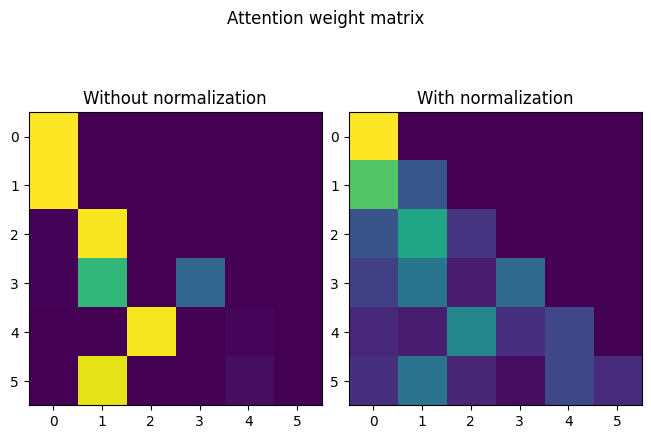

In [32]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, layout="constrained")
axs[0].imshow(attn)
axs[1].imshow(attn_norm)
axs[0].title.set_text("Without normalization")
axs[1].title.set_text("With normalization")
fig.suptitle("Attention weight matrix")
plt.show()


In [96]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, emb_size, head_size, block_size, dropout_p=0.2) -> None:
        super().__init__()

        self.head_size = head_size

        self.query = nn.Linear(emb_size, head_size, bias=False)
        self.key = nn.Linear(emb_size, head_size, bias=False)
        self.value = nn.Linear(emb_size, head_size, bias=False)

        self.register_buffer("tri", torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        B, T, C = x.shape

        q = self.query(x)  # (B, T, head_size)
        k = self.key(x)  # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)

        wei = q @ k.transpose(-2, -1)  # (B, T, head_size) @ (B, head_size, T) = (B, T, T)
        wei = wei * self.head_size**-0.5  # <-- "Scaled"
        wei = wei.masked_fill(self.tri[:T, :T] == 0, -torch.inf)
        wei = F.softmax(wei, dim=-1)

        out = self.dropout(wei) @ v  # (B, T, T) @ (B, T, head_size) = (B, T, head_size)

        return out, wei


Self-attention is typically combined with other layers to form a transformer block. There are a few more concepts we need before we are ready to do this. These are:

1. Skip connections
2. Layer normalization
3. Dropout


### Skip connections


In [97]:
# TODO describe:
# 1. "Highway" - Allows gradients to "flow". Crucial for deep networks
# 2. "Slowly come online" - Allows weight block to "kick in" over time during training


<img src="https://github.com/jbergq/nlp-refresher/blob/main/images/skip_connection.png?raw=1" height="512" style="margin:auto"/>

### Layer normalization


<img src="https://github.com/jbergq/nlp-refresher/blob/main/images/layer_norm.png?raw=1" height="512" style="margin:auto"/>


In [98]:
# TODO describe layer norm and why it is preferred


Let's put everything together and build our transformer block. Here it is:


In [99]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_size, head_size, num_heads=4, block_size=32, expansion=4, dropout_p=0.2) -> None:
        super().__init__()

        self.heads = nn.ModuleList(
            ScaledDotProductAttention(emb_size, head_size, block_size, dropout_p) for _ in range(num_heads)
        )
        self.proj = nn.Linear(head_size * num_heads, emb_size)
        self.dropout = nn.Dropout(dropout_p)

        # fmt: off
        self.ff = nn.Sequential(
            *[
                nn.Linear(emb_size, emb_size * expansion),
                nn.ReLU(),
                nn.Linear(emb_size * expansion, emb_size),
                nn.Dropout(dropout_p),
            ]
        )
        # fmt: on

        self.l1 = nn.LayerNorm(emb_size)
        self.l2 = nn.LayerNorm(emb_size)

    def forward_heads(self, x):
        head_outs, attns = tuple(map(list, zip(*[head(x) for head in self.heads])))
        heads_cat = torch.cat(head_outs, dim=-1)

        x = self.proj(heads_cat)
        x = self.dropout(x)

        return x, attns

    def forward(self, x):
        heads_out, attns = self.forward_heads(self.l1(x))
        x = x + heads_out
        x = x + self.ff(self.l2(x))

        return x, attns


Multiple transformer blocks can be stacked on top of each other to form a deeper network:


In [100]:
B, T, C = 1, 4, 2
x0 = torch.randn(B, T, C)

num_blocks = 4
blocks = [TransformerBlock(C, head_size=32, num_heads=4, block_size=32) for _ in range(num_blocks)]

xs = [x0]
attns = []
for block in blocks:
    x, attn = block(xs[-1])
    xs.append(x)
    attns.append(attn)

print("\n".join([str(x) for x in xs]))


tensor([[[ 1.9752,  1.5155],
         [-0.7368,  1.8039],
         [ 0.1917,  0.3469],
         [-0.6564, -0.6856]]])
tensor([[[ 2.3288,  2.8148],
         [-0.3553,  2.5968],
         [ 0.1879,  1.1562],
         [-0.3703, -0.6283]]], grad_fn=<AddBackward0>)
tensor([[[ 2.3288,  4.1470],
         [ 0.3778,  3.5279],
         [ 1.1096,  2.1001],
         [ 0.0198, -0.2164]]], grad_fn=<AddBackward0>)
tensor([[[ 2.4645,  5.0510],
         [ 0.0163,  4.3744],
         [ 1.1606,  3.0155],
         [ 0.3932, -0.2113]]], grad_fn=<AddBackward0>)
tensor([[[ 2.1601,  5.5004],
         [-0.3538,  4.7348],
         [ 1.0949,  3.4636],
         [ 0.0242, -0.7936]]], grad_fn=<AddBackward0>)


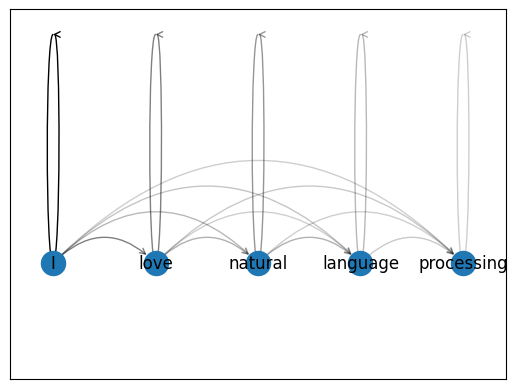

In [101]:
import networkx as nx


def visualize_attention_weights(labels, attention_weights):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes (tokens) to the graph
    for i, token in enumerate(labels):
        G.add_node(i)

    # Add weighted edges to the graph
    for i, label1 in enumerate(labels):
        for j, label2 in enumerate(labels):
            weight = attention_weights[i][j]
            G.add_edge(i, j, weight=weight)

    # Compute positions for the nodes with reversed order
    pos = {i: (len(labels) - 1 + i, 0) for i, token in enumerate(labels)}

    # Draw the graph
    nx.draw_networkx_nodes(G, pos)

    # Draw the edges with opacity based on attention weights
    for edge in G.edges(data=True):
        weight = edge[2]["weight"]
        nx.draw_networkx_edges(
            G, pos, edgelist=[(edge[0], edge[1])], connectionstyle="arc3,rad=0.5", alpha=weight, arrowstyle="<-"
        )

    # selfloop_edges = [(e, e) for e in nx.nodes_with_selfloops(G)]
    # nx.draw_networkx_edges(G, pos, edgelist=selfloop_edges)

    # Draw text labels for nodes
    nx.draw_networkx_labels(G, pos, labels, font_size=12, font_family="sans-serif")


tokens = ["I", "love", "natural", "language", "processing"]
attention_weights = [
    [0.2, 0.5, 0.1, 0.3, 0.1],
    [0.5, 0.5, 0.2, 0.1, 0.2],
    [0.1, 0.2, 0.5, 0.6, 0.1],
    [0.3, 0.1, 0.6, 0.5, 0.3],
    [0.1, 0.2, 0.1, 0.2, 0.1],
]
attention_weights = torch.tensor(attention_weights)
T = attention_weights.shape[0]
tri = torch.tril(torch.ones(T, T))
attention_weights = attention_weights.masked_fill(tri == 0, -torch.inf)
attention_weights = F.softmax(attention_weights, dim=1)

visualize_attention_weights({i: label for i, label in enumerate(tokens)}, attention_weights.tolist())


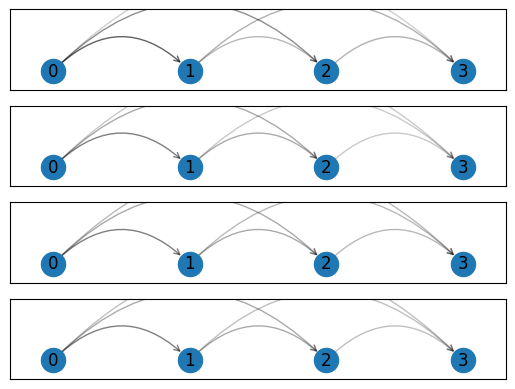

In [102]:
fig, ax = plt.subplots(num_blocks, 1, num=1)

for i, (x, attn) in enumerate(zip(xs, attns)):
    B, T, C = x.shape
    ix = np.unravel_index(i, ax.shape)
    plt.sca(ax[ix])
    visualize_attention_weights({i: i for i in range(T)}, attn[0].tolist()[0])

plt.show()


## Transformer implementation


Let's build a simple transformer!


In [108]:
class Transformer(LanguageModel):
    def __init__(self, emb_size, vocab_size, head_size, num_heads, block_size, num_blocks, expansion, dropout_p=0.2) -> None:
        super().__init__(block_size=block_size)

        self.emb = nn.Embedding(vocab_size, emb_size)
        self.pos_emb = nn.Embedding(block_size, emb_size)

        self.blocks = nn.ModuleList([
            TransformerBlock(emb_size, head_size, num_heads, block_size, expansion, dropout_p) for _ in range(num_blocks)
        ])

        self.ln_out = nn.LayerNorm(emb_size)
        self.out_head = nn.Linear(emb_size, vocab_size)

    def forward(self, x, targets=None):
        B, T = x.shape

        x = self.emb(x) + self.pos_emb(torch.arange(T, device=device))

        xs = [x]
        attns = []
        for block in self.blocks:
            x, attn = block(xs[-1])
            xs.append(x)
            attns.append(attn)

        logits = self.out_head(self.ln_out(xs[-1]))

        if targets is not None:
            B, T, C = logits.shape
            logits_ = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits_, targets)
        else:
            loss = None

        return logits, loss, xs, attns


emb_size = 64
num_heads = 4
head_size = emb_size // num_heads
block_size = 32
num_blocks = 4
batch_size = 32
expansion = 4
dropout_p = 0.0

model = Transformer(emb_size, vocab_size, head_size, num_heads, block_size, num_blocks, expansion, dropout_p)
model = model.to(device)


In [109]:
B, T, C = 1, 4, 2
x0 = torch.randn(B, T, C)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


In [110]:
for iter in range(int(1e4)):
    xb, yb = get_batch("train", block_size, batch_size)

    logits, loss, xs, attns = model(xb, yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if iter % 1000 == 0:
        print(f"Train loss: {loss}")


Train loss: 4.396475315093994
Train loss: 2.5302348136901855
Train loss: 2.2667019367218018
Train loss: 2.1362369060516357
Train loss: 2.191527843475342
Train loss: 2.099165201187134
Train loss: 2.0133678913116455
Train loss: 1.9583566188812256
Train loss: 1.8561772108078003
Train loss: 1.8665285110473633


In [111]:
output = model.generate(torch.zeros((1, 1), dtype=torch.long, device=device), 1000)

print(decode(output[0].tolist()))



A ange cale deay, but comtuon,
A Iston ever, but have: may hilt
Brooke takin is soust so vich for mone an hust the brase have;
And fir your your grid in youl, and be to so twoul the wilnnob,
she not in it Lale penow firsss.

HORIO:
I sir, deed for elieds in think
Uut, sucle he will and wheave Jarw Eloods he,
'Wowe son veny butunce, us from like you.

MOMAMES:
I bull with hould us loat for of Re's than evell
Ancome so fair, camore is you cusentue,
Op make the then ame mirdap, speak:
Thou bay have wrayich acknouss Pa vaSe oyour so
ard Lord! and frinedss.
The that rowll to frived that the sainate
Brow hatanins nightes
bed, my dare you shelf, whom be sarman, bean;
And so?
He the fighting a gind
My thein feld indory sprother of nee's how exper,
To nettumise to nigh a coshcen of shough.

PORIOM:
hy should, det's ichoursent should you shald mysarveng us touke, hous day. Wusel's have the tis scones bamus evern accouss to your to ours.

JORRDUS:
Empriont, thee are, shall affitl to ren iffurett

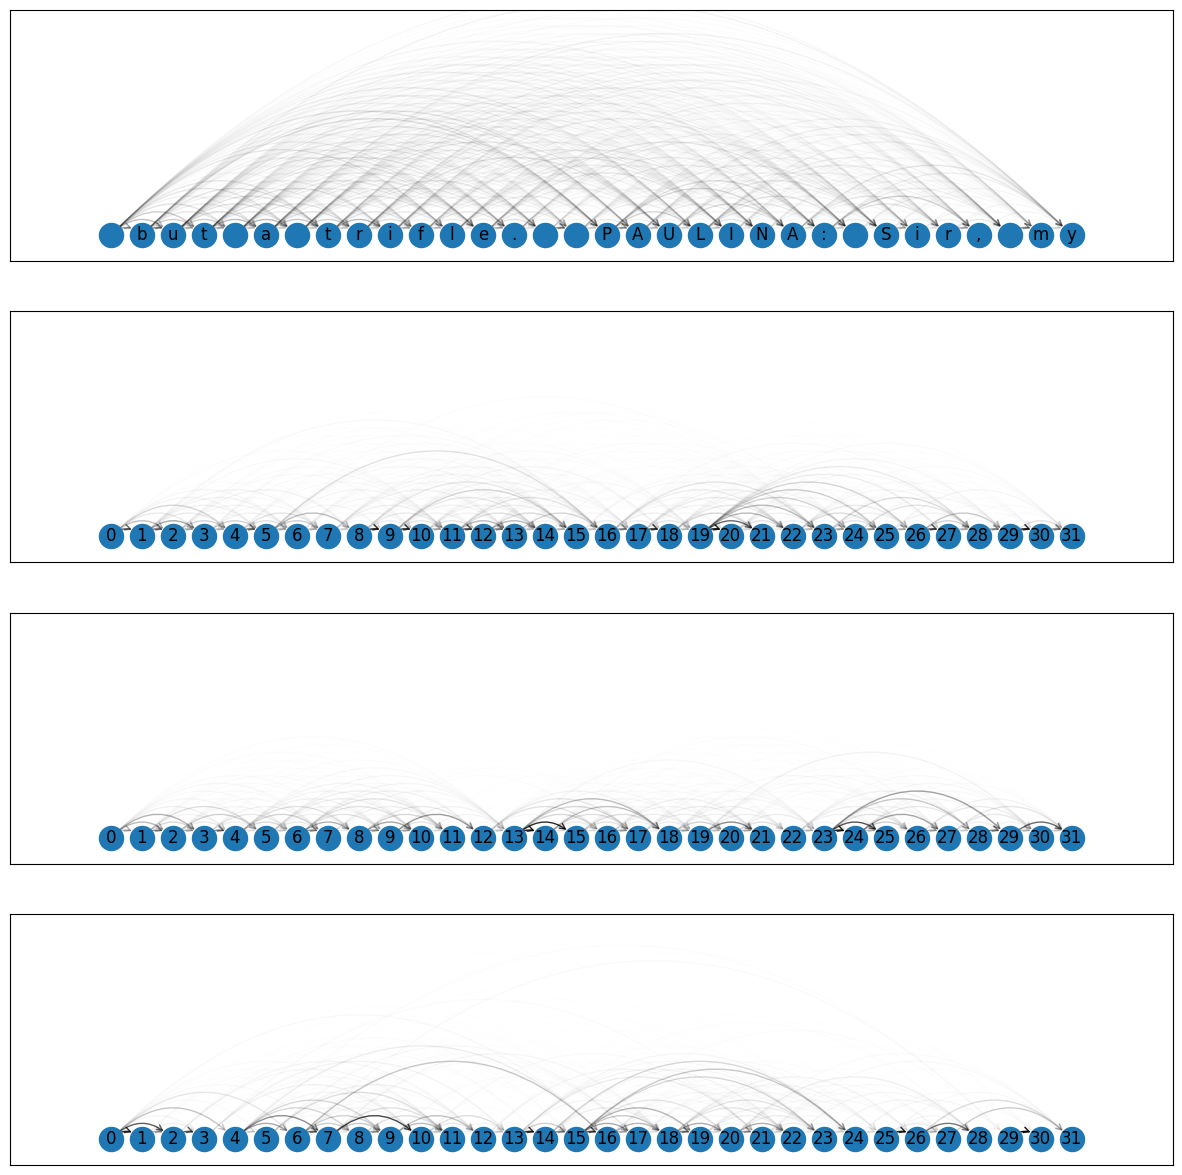

In [112]:
fig, ax = plt.subplots(num_blocks, 1, num=1, figsize=(15, 15))

for i, (x, attn) in enumerate(zip(xs, attns)):
    ix = np.unravel_index(i, ax.shape)
    plt.sca(ax[ix])

    if i == 0:
        labels = {i: label for i, label in enumerate(decode(xb[0].tolist()))}
    else:
        labels = {i: i for i in range(xb.shape[1])}

    visualize_attention_weights(labels, attn[0].tolist()[0])

plt.show()
